Using device: cuda
GPU: Tesla T4
Memory: 15.7 GB

Loading data...
Shape: 713 times × 141 lat × 281 lon

Preparing image data...
X shape: (713, 5, 141, 281)
Y shape: (713, 1, 141, 281)

Normalizing features...
Normalized X range: [-88.14, 116.86]

Splitting data...
Train: 499 samples
Val:   106 samples
Test:  108 samples

Batch size: 8
Train batches: 63

Training CNN
Epoch   1/30 | Train Loss: 1.2509 | Val Loss: 1.0018 | AUC: 0.6304 | Recall: 0.4830
Epoch   5/30 | Train Loss: 1.1360 | Val Loss: 0.9429 | AUC: 0.7096 | Recall: 0.6239
Epoch  10/30 | Train Loss: 1.0624 | Val Loss: 0.9727 | AUC: 0.7132 | Recall: 0.6721
Epoch  15/30 | Train Loss: 1.0166 | Val Loss: 0.8868 | AUC: 0.7401 | Recall: 0.6336
Epoch  20/30 | Train Loss: 0.9727 | Val Loss: 0.9163 | AUC: 0.7239 | Recall: 0.5200
Epoch  25/30 | Train Loss: 0.8980 | Val Loss: 1.0001 | AUC: 0.7203 | Recall: 0.5682
Epoch  30/30 | Train Loss: 0.8439 | Val Loss: 0.9727 | AUC: 0.7196 | Recall: 0.5310

Best Val AUC: 0.7401

Training UNet
Epoch 

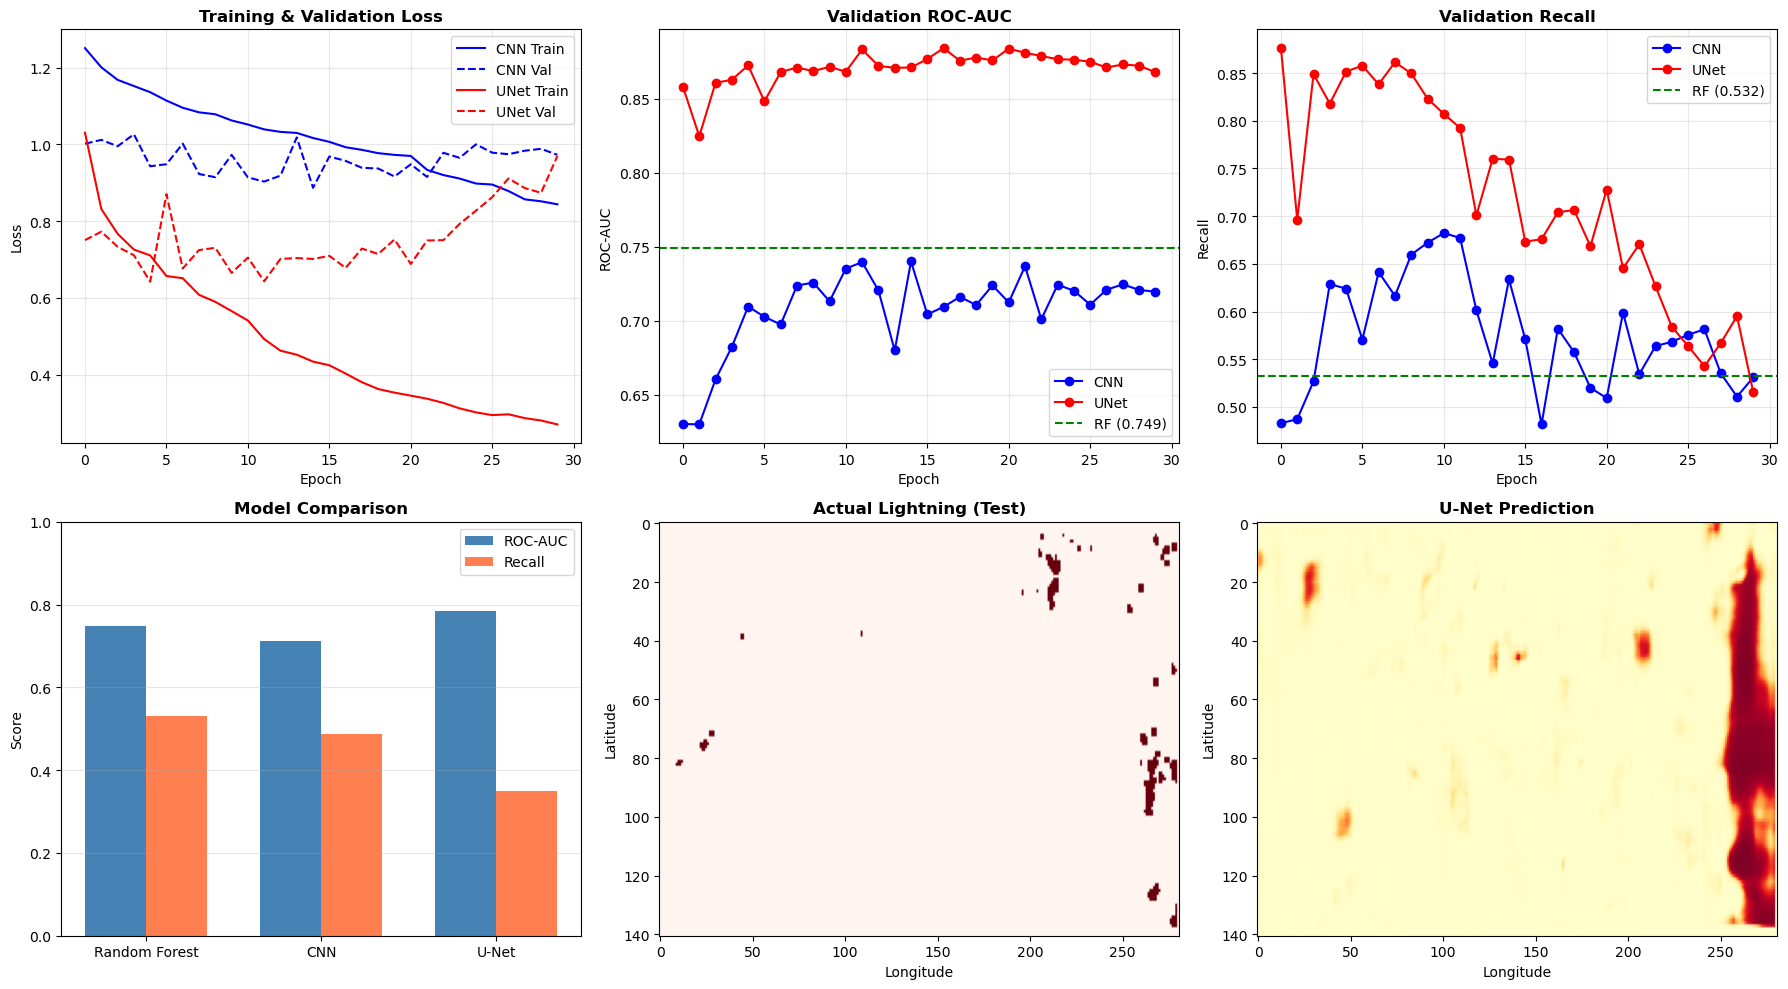


✓ Figure saved: cnn_unet_results.png

FINAL SUMMARY FOR PPT

Model Performance Comparison:

| Model         | ROC-AUC | Recall  | Precision |
|---------------|---------|---------|-----------|
| Random Forest | 0.749   | 53.2%   | 2.6%      |
| CNN           | 0.711   | 48.8%   | 2.0%      |
| U-Net         | 0.785   | 35.0%   | 6.5%      |

Key Findings:
1. RF treats each pixel independently
2. CNN/U-Net capture spatial patterns
3. U-Net has skip connections for better detail

Training Details:
- Input: 5 ERA5 channels (CAPE, precip, temp, humidity, velocity)
- Output: Binary lightning map (141 × 281)
- Epochs: 30
- Batch size: 8
- Loss: Weighted BCE (pos_weight=100)

COMPLETE!


In [1]:
# =============================================================
# CNN & U-NET FOR LIGHTNING PREDICTION
# =============================================================

# =============================================================
# 1. LIBRARIES
# =============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# =============================================================
# 2. LOAD DATA
# =============================================================
print("\nLoading data...")
ds = xr.open_dataset('lightning_era5_merged_july2024.nc')

# Get dimensions
n_times = len(ds.time)
n_lats = len(ds.latitude)
n_lons = len(ds.longitude)
print(f"Shape: {n_times} times × {n_lats} lat × {n_lons} lon")

# =============================================================
# 3. PREPARE DATA AS IMAGES
# =============================================================
print("\nPreparing image data...")

# Features (5 channels)
features = ['convective_available_potential_energy',
            'total_precipitation',
            '2m_temperature',
            'total_column_water_vapour',
            'vertical_velocity']

# Stack features into array: (time, channels, lat, lon)
X_list = []
for feat in features:
    X_list.append(ds[feat].values)

X = np.stack(X_list, axis=1)  # (713, 5, 141, 281)
print(f"X shape: {X.shape}")

# Target: binary lightning (time, 1, lat, lon)
Y = (ds['lightning_density'].values > 0).astype(np.float32)
Y = Y[:, np.newaxis, :, :]  # Add channel dimension
print(f"Y shape: {Y.shape}")

# =============================================================
# 4. NORMALIZE FEATURES
# =============================================================
print("\nNormalizing features...")

# Calculate mean and std per channel
X_mean = X.mean(axis=(0, 2, 3), keepdims=True)
X_std = X.std(axis=(0, 2, 3), keepdims=True)

X_normalized = (X - X_mean) / (X_std + 1e-8)
print(f"Normalized X range: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

# =============================================================
# 5. TRAIN/VAL/TEST SPLIT (by time)
# =============================================================
print("\nSplitting data...")

n_train = int(0.7 * n_times)
n_val = int(0.15 * n_times)

X_train = X_normalized[:n_train]
Y_train = Y[:n_train]

X_val = X_normalized[n_train:n_train+n_val]
Y_val = Y[n_train:n_train+n_val]

X_test = X_normalized[n_train+n_val:]
Y_test = Y[n_train+n_val:]

print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# =============================================================
# 6. PYTORCH DATASET
# =============================================================
class LightningDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create datasets
train_dataset = LightningDataset(X_train, Y_train)
val_dataset = LightningDataset(X_val, Y_val)
test_dataset = LightningDataset(X_test, Y_test)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")

# =============================================================
# 7. SIMPLE CNN MODEL
# =============================================================
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=5):
        super(SimpleCNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.encoder(x)

# =============================================================
# 8. U-NET MODEL
# =============================================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool3(e3))
        
        # Decoder with skip connections
        d3 = self.up3(b)
        # Handle size mismatch
        d3 = self._pad_to_match(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        
        d2 = self.up2(d3)
        d2 = self._pad_to_match(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        
        d1 = self.up1(d2)
        d1 = self._pad_to_match(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        
        return self.sigmoid(self.out_conv(d1))
    
    def _pad_to_match(self, x, target):
        diff_h = target.size(2) - x.size(2)
        diff_w = target.size(3) - x.size(3)
        x = nn.functional.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                                   diff_h // 2, diff_h - diff_h // 2])
        return x

# =============================================================
# 9. WEIGHTED LOSS FUNCTION (for imbalanced data)
# =============================================================
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=100):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
    
    def forward(self, pred, target):
        # Weight positive samples more
        weight = torch.where(target == 1, 
                            torch.tensor(self.pos_weight, device=pred.device),
                            torch.tensor(1.0, device=pred.device))
        bce = -weight * (target * torch.log(pred + 1e-8) + 
                        (1 - target) * torch.log(1 - pred + 1e-8))
        return bce.mean()

# =============================================================
# 10. TRAINING FUNCTION
# =============================================================
def train_model(model, train_loader, val_loader, epochs=30, model_name="Model"):
    model = model.to(device)
    criterion = WeightedBCELoss(pos_weight=100)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_recall': []}
    best_auc = 0
    
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                pred = model(X_batch)
                loss = criterion(pred, Y_batch)
                val_loss += loss.item()
                
                all_preds.append(pred.cpu().numpy().flatten())
                all_targets.append(Y_batch.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        
        # Calculate metrics
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        
        val_auc = roc_auc_score(all_targets, all_preds)
        val_recall = recall_score(all_targets, (all_preds > 0.5).astype(int))
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_recall'].append(val_recall)
        
        # Learning rate scheduler
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | Recall: {val_recall:.4f}")
        
        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), f'{model_name.lower()}_best.pt')
    
    print(f"\nBest Val AUC: {best_auc:.4f}")
    return model, history

# =============================================================
# 11. EVALUATION FUNCTION
# =============================================================
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(Y_batch.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Flatten for metrics
    preds_flat = all_preds.flatten()
    targets_flat = all_targets.flatten()
    
    auc = roc_auc_score(targets_flat, preds_flat)
    preds_binary = (preds_flat > 0.5).astype(int)
    recall = recall_score(targets_flat, preds_binary)
    precision = precision_score(targets_flat, preds_binary, zero_division=0)
    f1 = f1_score(targets_flat, preds_binary)
    
    print(f"\n{'='*50}")
    print(f"{model_name} TEST RESULTS")
    print(f"{'='*50}")
    print(f"ROC-AUC:   {auc:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    return {'auc': auc, 'recall': recall, 'precision': precision, 'f1': f1}, all_preds, all_targets

# =============================================================
# 12. TRAIN BOTH MODELS
# =============================================================
# Train CNN
cnn_model = SimpleCNN(in_channels=5)
cnn_model, cnn_history = train_model(cnn_model, train_loader, val_loader, epochs=30, model_name="CNN")

# Train U-Net
unet_model = UNet(in_channels=5, out_channels=1)
unet_model, unet_history = train_model(unet_model, train_loader, val_loader, epochs=30, model_name="UNet")

# =============================================================
# 13. EVALUATE ON TEST SET
# =============================================================
cnn_metrics, cnn_preds, cnn_targets = evaluate_model(cnn_model, test_loader, "CNN")
unet_metrics, unet_preds, unet_targets = evaluate_model(unet_model, test_loader, "UNet")

# =============================================================
# 14. COMPARE ALL MODELS
# =============================================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Recall':<12} {'Precision':<12}")
print("-"*60)
print(f"{'Random Forest':<15} {0.749:<12.4f} {0.532:<12.4f} {0.026:<12.4f}")
print(f"{'CNN':<15} {cnn_metrics['auc']:<12.4f} {cnn_metrics['recall']:<12.4f} {cnn_metrics['precision']:<12.4f}")
print(f"{'U-Net':<15} {unet_metrics['auc']:<12.4f} {unet_metrics['recall']:<12.4f} {unet_metrics['precision']:<12.4f}")

# =============================================================
# 15. PLOTS
# =============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Training Loss
axes[0, 0].plot(cnn_history['train_loss'], 'b-', label='CNN Train')
axes[0, 0].plot(cnn_history['val_loss'], 'b--', label='CNN Val')
axes[0, 0].plot(unet_history['train_loss'], 'r-', label='UNet Train')
axes[0, 0].plot(unet_history['val_loss'], 'r--', label='UNet Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation AUC
axes[0, 1].plot(cnn_history['val_auc'], 'b-o', label='CNN')
axes[0, 1].plot(unet_history['val_auc'], 'r-o', label='UNet')
axes[0, 1].axhline(y=0.749, color='g', linestyle='--', label='RF (0.749)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].set_title('Validation ROC-AUC', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Validation Recall
axes[0, 2].plot(cnn_history['val_recall'], 'b-o', label='CNN')
axes[0, 2].plot(unet_history['val_recall'], 'r-o', label='UNet')
axes[0, 2].axhline(y=0.532, color='g', linestyle='--', label='RF (0.532)')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].set_title('Validation Recall', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Model Comparison Bar Chart
models = ['Random Forest', 'CNN', 'U-Net']
aucs = [0.749, cnn_metrics['auc'], unet_metrics['auc']]
recalls = [0.532, cnn_metrics['recall'], unet_metrics['recall']]

x = np.arange(len(models))
width = 0.35
axes[1, 0].bar(x - width/2, aucs, width, label='ROC-AUC', color='steelblue')
axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='coral')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Model Comparison', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 5: U-Net Prediction Example (last test image)
test_idx = -1
actual = unet_targets[test_idx, 0]
predicted = unet_preds[test_idx, 0]

axes[1, 1].imshow(actual, cmap='Reds', aspect='auto')
axes[1, 1].set_title('Actual Lightning (Test)', fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')

axes[1, 2].imshow(predicted, cmap='YlOrRd', aspect='auto')
axes[1, 2].set_title('U-Net Prediction', fontweight='bold')
axes[1, 2].set_xlabel('Longitude')
axes[1, 2].set_ylabel('Latitude')

plt.tight_layout()
plt.savefig('cnn_unet_results.png', dpi=150)
plt.show()

print("\n✓ Figure saved: cnn_unet_results.png")

# =============================================================
# 16. FINAL SUMMARY
# =============================================================
print("\n" + "="*60)
print("FINAL SUMMARY FOR PPT")
print("="*60)
print(f"""
Model Performance Comparison:

| Model         | ROC-AUC | Recall  | Precision |
|---------------|---------|---------|-----------|
| Random Forest | 0.749   | 53.2%   | 2.6%      |
| CNN           | {cnn_metrics['auc']:.3f}   | {cnn_metrics['recall']*100:.1f}%   | {cnn_metrics['precision']*100:.1f}%      |
| U-Net         | {unet_metrics['auc']:.3f}   | {unet_metrics['recall']*100:.1f}%   | {unet_metrics['precision']*100:.1f}%      |

Key Findings:
1. RF treats each pixel independently
2. CNN/U-Net capture spatial patterns
3. U-Net has skip connections for better detail

Training Details:
- Input: 5 ERA5 channels (CAPE, precip, temp, humidity, velocity)
- Output: Binary lightning map (141 × 281)
- Epochs: 30
- Batch size: {batch_size}
- Loss: Weighted BCE (pos_weight=100)
""")

print("="*60)
print("COMPLETE!")
print("="*60)


Training Improved U-Net
Dropout: 0.3
Weight Decay: 1e-4
Early Stopping Patience: 10
Data Augmentation: ON

Epoch   1/50 | Train Loss: 1.3094 | Val Loss: 1.0119 | AUC: 0.6690 | Recall: 0.3996
Epoch   5/50 | Train Loss: 1.1765 | Val Loss: 1.0617 | AUC: 0.7339 | Recall: 0.8484
Epoch  10/50 | Train Loss: 1.0940 | Val Loss: 0.9365 | AUC: 0.7546 | Recall: 0.8784
Epoch  15/50 | Train Loss: 1.0452 | Val Loss: 1.0261 | AUC: 0.7353 | Recall: 0.8538

Early stopping at epoch 17

Best Val Loss: 0.8913
Best Val AUC: 0.7632

IMPROVED U-NET TEST RESULTS
ROC-AUC:   0.7002
Recall:    0.5837
Precision: 0.0172

FINAL MODEL COMPARISON
Model                ROC-AUC      Recall       Precision   
------------------------------------------------------------
Random Forest        0.7490       0.5320       0.0260      
CNN                  0.7010       0.5290       0.0190      
U-Net (original)     0.7740       0.2860       0.0610      
U-Net (improved)     0.7002       0.5837       0.0172      


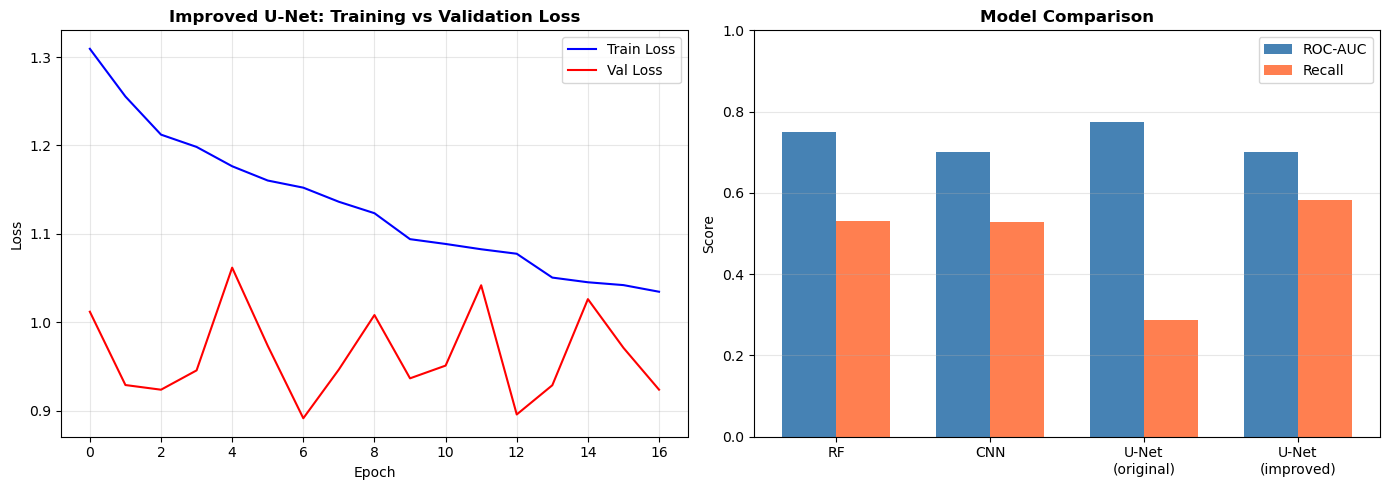


✓ Figure saved: unet_improved_results.png


In [2]:
# =============================================================
# IMPROVED U-NET (with overfitting fixes)
# =============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# =============================================================
# 1. DATA AUGMENTATION
# =============================================================
class LightningDatasetAugmented(Dataset):
    def __init__(self, X, Y, augment=False):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
        self.augment = augment
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        
        if self.augment:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[2])  # flip longitude
                y = torch.flip(y, dims=[2])
            
            # Random vertical flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[1])  # flip latitude
                y = torch.flip(y, dims=[1])
            
            # Add small noise
            x = x + torch.randn_like(x) * 0.1
        
        return x, y

# =============================================================
# 2. SMALLER U-NET WITH DROPOUT
# =============================================================
class DoubleConvDropout(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3):
        super(DoubleConvDropout, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),  # Dropout after first conv
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, dropout=0.3):
        super(UNetSmall, self).__init__()
        
        # Smaller filters (32, 64, 128 instead of 64, 128, 256, 512)
        # Encoder
        self.enc1 = DoubleConvDropout(in_channels, 32, dropout)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConvDropout(32, 64, dropout)
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck (smaller)
        self.bottleneck = DoubleConvDropout(64, 128, dropout)
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConvDropout(128, 64, dropout)
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConvDropout(64, 32, dropout)
        
        # Output
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        
        # Bottleneck
        b = self.bottleneck(self.pool2(e2))
        
        # Decoder with skip connections
        d2 = self.up2(b)
        d2 = self._pad_to_match(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        
        d1 = self.up1(d2)
        d1 = self._pad_to_match(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        
        return self.sigmoid(self.out_conv(d1))
    
    def _pad_to_match(self, x, target):
        diff_h = target.size(2) - x.size(2)
        diff_w = target.size(3) - x.size(3)
        x = nn.functional.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                                   diff_h // 2, diff_h - diff_h // 2])
        return x

# =============================================================
# 3. TRAINING WITH EARLY STOPPING & WEIGHT DECAY
# =============================================================
def train_unet_improved(model, train_loader, val_loader, epochs=50, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Weighted loss
    criterion = WeightedBCELoss(pos_weight=100)
    
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_recall': []}
    best_val_loss = float('inf')
    best_auc = 0
    patience_counter = 0
    
    print(f"\n{'='*50}")
    print("Training Improved U-Net")
    print(f"{'='*50}")
    print(f"Dropout: 0.3")
    print(f"Weight Decay: 1e-4")
    print(f"Early Stopping Patience: {patience}")
    print(f"Data Augmentation: ON")
    print(f"{'='*50}\n")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                pred = model(X_batch)
                loss = criterion(pred, Y_batch)
                val_loss += loss.item()
                
                all_preds.append(pred.cpu().numpy().flatten())
                all_targets.append(Y_batch.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        
        # Calculate metrics
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        
        val_auc = roc_auc_score(all_targets, all_preds)
        val_recall = recall_score(all_targets, (all_preds > 0.5).astype(int))
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_recall'].append(val_recall)
        
        # Learning rate scheduler
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | Recall: {val_recall:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), 'unet_improved_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('unet_improved_best.pt'))
    print(f"\nBest Val Loss: {best_val_loss:.4f}")
    print(f"Best Val AUC: {best_auc:.4f}")
    
    return model, history

# =============================================================
# 4. CREATE DATASETS WITH AUGMENTATION
# =============================================================
# Training with augmentation
train_dataset_aug = LightningDatasetAugmented(X_train, Y_train, augment=True)
val_dataset = LightningDatasetAugmented(X_val, Y_val, augment=False)
test_dataset = LightningDatasetAugmented(X_test, Y_test, augment=False)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# =============================================================
# 5. TRAIN IMPROVED U-NET
# =============================================================
unet_improved = UNetSmall(in_channels=5, out_channels=1, dropout=0.3)
unet_improved, history_improved = train_unet_improved(
    unet_improved, train_loader_aug, val_loader, epochs=50, patience=10
)

# =============================================================
# 6. EVALUATE
# =============================================================
unet_improved.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = unet_improved(X_batch)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(Y_batch.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

preds_flat = all_preds.flatten()
targets_flat = all_targets.flatten()

auc_improved = roc_auc_score(targets_flat, preds_flat)
preds_binary = (preds_flat > 0.5).astype(int)
recall_improved = recall_score(targets_flat, preds_binary)
precision_improved = precision_score(targets_flat, preds_binary, zero_division=0)

print(f"\n{'='*50}")
print("IMPROVED U-NET TEST RESULTS")
print(f"{'='*50}")
print(f"ROC-AUC:   {auc_improved:.4f}")
print(f"Recall:    {recall_improved:.4f}")
print(f"Precision: {precision_improved:.4f}")

# =============================================================
# 7. COMPARE ALL MODELS
# =============================================================
print(f"\n{'='*60}")
print("FINAL MODEL COMPARISON")
print(f"{'='*60}")
print(f"{'Model':<20} {'ROC-AUC':<12} {'Recall':<12} {'Precision':<12}")
print("-"*60)
print(f"{'Random Forest':<20} {0.749:<12.4f} {0.532:<12.4f} {0.026:<12.4f}")
print(f"{'CNN':<20} {0.701:<12.4f} {0.529:<12.4f} {0.019:<12.4f}")
print(f"{'U-Net (original)':<20} {0.774:<12.4f} {0.286:<12.4f} {0.061:<12.4f}")
print(f"{'U-Net (improved)':<20} {auc_improved:<12.4f} {recall_improved:<12.4f} {precision_improved:<12.4f}")

# =============================================================
# 8. PLOT COMPARISON
# =============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves (should be closer now)
axes[0].plot(history_improved['train_loss'], 'b-', label='Train Loss')
axes[0].plot(history_improved['val_loss'], 'r-', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Improved U-Net: Training vs Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Model comparison
models = ['RF', 'CNN', 'U-Net\n(original)', 'U-Net\n(improved)']
aucs = [0.749, 0.701, 0.774, auc_improved]
recalls = [0.532, 0.529, 0.286, recall_improved]

x = np.arange(len(models))
width = 0.35
axes[1].bar(x - width/2, aucs, width, label='ROC-AUC', color='steelblue')
axes[1].bar(x + width/2, recalls, width, label='Recall', color='coral')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Comparison', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('unet_improved_results.png', dpi=150)
plt.show()

print("\n✓ Figure saved: unet_improved_results.png")